# Modelling

This notebook tests and describes the procedure to model the data.

## Preamble

In [1]:
# load basic libraries
import numpy as np
import os
import sys
import re
import pandas as pd
from importlib import reload

# load other libraries
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split

from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE


# add ./python to python path
sys.path.insert(0, '../python')

# load local libraries
import cleaning
import text_processing
import modelling

## Options

In [2]:
# options
data_dir = '../0_data/training'

# input file
path = data_dir+'/NOTAM.csv'

# intermediate files to train
# and build the model
path_train = path.replace('.csv', '_train_clean.csv')
path_test = path.replace('.csv', '_test_clean.csv')

plt.style.use('seaborn-whitegrid')

plt.rc('pdf', fonttype=42)
sns.mpl.rc('figure', figsize = (10, 8))
sns.set_context('notebook', font_scale=2.0, rc={'lines.linewidth': 2.5})

pd.set_option('display.max_columns', 500)

## Data modelling

The steps below describe how to run the modelling workflow. First split the current into training and test sample to train the model, then perform training and testing.

In [3]:
# define a random state for reproductability
random_state = 20091982

### Training/test splitting

In [4]:

if False:
    df = pd.read_csv(path, sep=',').set_index('item_id')
    df_train, df_test = train_test_split(
        df, train_size=0.8, test_size=0.2, random_state=random_state)
    df_train.to_csv(path_train)
    df_test.to_csv(path_test)
    
else:
    # first run
    # python/split.py 0_Data/23-08-2018/Export.txt 0_Data/training/NOTAM_train.csv,0_Data/training/NOTAM_test.csv
    # and python/main.py clean 0_Data/training/NOTAM_train.csv
    # and python/main.py clean 0_Data/training/NOTAM_test.csv

    df_train = pd.read_csv(path_train)
    df_test = pd.read_csv(path_test)

### Training

The training phase will perform the following steps:
* build a dictionary from a csv file that contains the cleaned NOTAMs,
* performs hierarchical clustering,

In [5]:
# takes into account changes
# made in the modelling.py file
reload(modelling)

# create model training object
model_train = modelling.ModelTraining(path_train)

# build a vocabulary and saves it in python/
model_train.build_vocabulary()

# vectorize the NOTAMs and do
# dimensionality reduction
model_train.vectorize()

# train and persist model
model_train.cluster_train(
    path_train.replace('.csv', '_model.pickle'), n_samples=100)

Reading file...done (found 78837 NOTAMs).
Building and saving the dictionary...done.
Vectorizing the NOTAMs...done.
Performing dimensionality reduction...done.
Training (clusters)...done.


In [6]:
# optionally:
# - get the dictionary:
vocabulary_dict = model_train.get_vocabulary_dict()
# - get the word vector
vector_train = model_train.get_vector()
# - get the target (important/unimportant)
target_train = model_train.get_df()['important'].values

### Test/predict

In [7]:
reload(modelling)

# create model training object
model_test = modelling.ModelTraining(path_test)

# vectorize the NOTAMs and do
# dimensionality reduction
model_test.vectorize()

Reading file...done (found 19710 NOTAMs).
Vectorizing the NOTAMs...done.
Performing dimensionality reduction...done.


In [8]:
reload(modelling)

# get the word vector and perform 
# t-SNE manifold representation
# for visualisation
vector_test = model_test.get_vector()

target_test = model_test.get_df()['important'].values

In [10]:
# compute t-SNE representation
# additional info can be
# found here https://distill.pub/2016/misread-tsne/

# drives the number of neighbours in t-SNE
perplexity = 100

# file to store the t-SNE results
path_test_TSNE = path_test.replace('.csv', '_TSNE_perp{}.csv'.format(perplexity))

# it takes about 30 mn so we save 
# the result to a file
if False:
    test_TSNE = modelling.tsne(vector_test, random_state=random_state, perplexity=perplexity)
    pd.DataFrame(test_TSNE).to_csv(path_test_TSNE)
else:
    test_TSNE = pd.read_csv(path_test_TSNE)[['0', '1']].values

In [12]:
reload(modelling)

# plot the t-SNE representation
path_test_html = path_test_TSNE.replace('.csv', '.html')
modelling.plot_clusters(
    test_TSNE, model_test.get_df()['important'], 
    text= model_test.get_df()['fulltext'],
    label_names={True:'Important', False:'Unimportant'},
    html_out=path_test_html,
    interactive=True)

Plotting 9045 points with label Unimportant
Plotting 10665 points with label Important


## Tests

The section performs a few tests.

### Line breaks for plotting

In [13]:
reload(modelling)

text_test = model_test.get_df()['text'].values
text_test_breaks = modelling.break_lines(text_test)

if True:
    for i in range(10):
        print(text_test[i])
        print(text_test_breaks[i])
        print()

TWY B BTN RWY 17R/35L AND TWY M CLSD
TWY B BTN RWY 17R/35L AND TWY M CLSD

MBST/WS DETECTION SYSTEM NOT AVBL
MBST/WS DETECTION SYSTEM NOT AVBL

RWY 07/25 CLSD Z POWODU WIP.
RWY 07/25 CLSD Z POWODU WIP.

DANGER AREA EYD9 PABRADE ACT
DANGER AREA EYD9 PABRADE ACT

TWY R BTN TWY S14 AND TWY R10 CLSD. TWY S16 CLSD.
TWY R BTN TWY S14 AND TWY R10 CLSD. TWY S16 CLSD.

RWY 32 RWY END ID LGT U/S
RWY 32 RWY END ID LGT U/S

TWY N BTN TWY R AND TWY C CLSD
TWY N BTN TWY R AND TWY C CLSD

RACER SEVEN DEPARTURE... BUTLER TRANSITION,SPRINGFIELD TRANSITION NA EXCEPT FOR AIRCRAFT EQUIPPED WITH SUITABLE RNAV SYSTEM WITH GPS. DOSOA TRANSITION DME REQUIRED EXCEPT FOR AIRCRAFT EQUIPPED WITH SUITABLE RNAV SYSTEM WITH GPS, BUM VORTAC U/S
RACER SEVEN DEPARTURE... BUTLER TRANSITION,SPRINGFIELD TRANS<br>ITION NA EXCEPT FOR AIRCRAFT EQUIPPED WITH SUITABLE RNAV SYS<br>TEM WITH GPS. DOSOA TRANSITION DME REQUIRED EXCEPT FOR AIRCR<br>AFT EQUIPPED WITH SUITABLE RNAV SYSTEM WITH GPS, BUM VORTAC <br>U/S

RWY 16/34 CLSD A

In [14]:
df = model_train.get_df()
df.head()

,folder_id,keyvalue,cat_id,svt,evt,validfromt,validtot,profcat,active,dataclass,wdays,rvt,rvid,crt,crid,source,vrnr,priority,spare,transcode,offical,supress,areaissued,notprefix,notserial,notyear,partno,notamcode,trafficind,notpurpose,notscope,minflt,maxflt,subj,briefingcard,printcat,IsNew,qsign,qstat,lat,lng,radius,severity,last_modified_dt,EstimatedEvt,item_id_1,fulltext,txt_id,HEX(id),text,text_clean,important
item_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4583789,-1,XXXX,3,2018-06-07 03:59:00.000,2038-01-01 00:00:00.000,0,0,2,1,TXT,127,2018-06-07 11:15:00.000,1677,2018-06-07 04:03:00.000,1,EUC,1,1,0,R,1,0,WRRR,WA,B4098,18,,QLFAS,I,BO,A,0,999,NaN,0,-1,0,NaN,NaN,-5110,84250,5,0,NaN,2018-09-06 08:00:00.000,4583789,B4098/18 NOTAMR B1528/18 Q)WAAF/QLFAS/I/BO/A/0...,11,0x00003F3F,SQFL (SEQUENCE FLASHING LIGHTS) RWY 16 U/S DUE...,sqfl sfl rwy <num> u s due to electrical pro...,True
4650267,-1,XXXX,5,2018-06-27 13:00:00.000,2018-06-28 19:00:00.000,0,0,2,1,TXT,127,2018-06-27 05:08:00.000,1698,2018-06-26 19:46:00.000,1,EUC,1,1,0,N,1,0,KZMA,KZ,A1037,18,,QRACA,I,NBO,W,0,999,NaN,0,-1,0,NaN,NaN,16580,-48730,24,0,NaN,NaN,4650267,A1037/18 NOTAMN Q)KZMA/QRACA/I/NBO/W/000/999/2...,11,0x00003F3F,AIRSPACE RESERVATION AVON HI COMPLEX ACT. MIAM...,airspace rsvn avon hi complex act miami cente...,True
4637946,2782,XXXX,3,2018-06-25 12:00:00.000,2018-06-28 21:00:00.000,0,0,2,0,TXT,127,2018-06-28 18:01:00.000,1302,2018-06-22 12:57:00.000,1,EUC,1,1,0,N,1,0,KMIA,KZ,A2005,18,,QMXHW,IV,M,A,0,999,NaN,0,-1,0,NaN,NaN,15480,-48170,5,0,NaN,NaN,4637946,A2005/18 NOTAMN Q)KZMA/QMXHW/IV/M/A/000/999/25...,11,0x00003F3F,TWY ALL WIP INSPECTION,twy all wip inspection,True
4624075,-1,XXXX,3,2018-06-19 07:50:00.000,2038-01-01 00:00:00.000,0,0,2,1,TXT,127,2018-06-19 10:14:00.000,1589,2018-06-19 08:10:00.000,1,EUC,1,1,0,R,1,0,OPKC,OP,A0588,18,,QMNHW,IV,BO,A,0,999,NaN,0,-1,0,NaN,NaN,18150,40160,5,0,NaN,2018-09-20 23:59:00.000,4624075,A0588/18 NOTAMR A0247/18 Q)OPLR/QMNHW/IV/BO/A/...,11,0x00003F3F,FOKKER/ATR APRON NOT AVBL DUE REHABILITATION WIP,fokker atr apron not avbl due rehabilitation wip,True
4612312,-1,XXXX,3,2018-06-13 10:28:00.000,2038-01-01 00:00:00.000,0,0,2,0,TXT,127,2018-08-11 09:24:00.000,1677,2018-06-15 08:04:00.000,1,EUC,1,1,1,R,1,0,HECA,HE,A0169,18,,QPDXX,I,NBO,A,0,999,NaN,0,-1,0,NaN,NaN,14380,19690,5,0,NaN,2019-09-01 08:00:00.000,4612312,A0169/18 NOTAMR A0254/17 Q)HECC/QPDXX/I/NBO/A/...,11,0x00003F3F,AIP SUP 15/14 EXTENDED.,aip sup <num> <num> extended,True


### Word counts

In [15]:
# word counts
# TODO: try 2-gram
# vectorizer = CountVectorizer(ngram_range=(1, 2), token_pattern=r'\b\w+\b', min_df=1)
vectorizer = CountVectorizer(stop_words='english')

# get the NOTAMS as a corpus
corpus = df['text_clean'].fillna('').values
word_counts = vectorizer.fit_transform(corpus)

In [16]:
# what are the typical words that appear most frequently?
print(word_counts.shape)
word_total_counts = word_counts.toarray().sum(axis=0)

# sorted indexes (most frequent first)
word_total_counts_sorted = -np.sort(-word_total_counts)
word_total_counts_sorted_ids = np.argsort(-word_total_counts)

(78837, 25419)


In [17]:
inverse_dictionary = {v:k for (k,v) in vectorizer.vocabulary_.items()}

### Most frequent words

In [18]:
n_most_frequent = 100
most_frequent = word_counts[:, word_total_counts_sorted_ids[:n_most_frequent]].toarray()

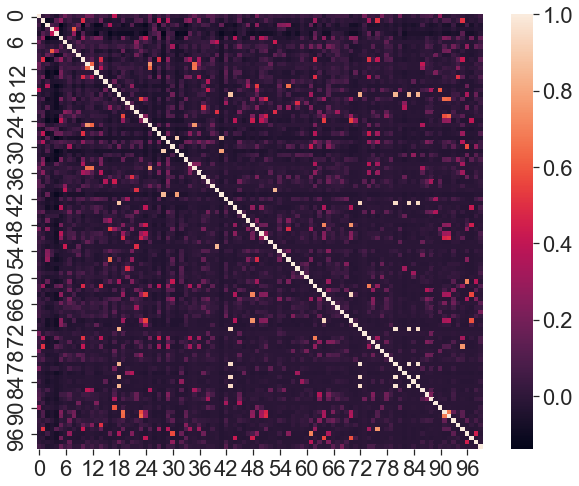

In [19]:
cov = np.corrcoef(most_frequent, rowvar=False)
sns.heatmap(cov)
None

In [20]:
feature_most_frequent = []
for index in word_total_counts_sorted_ids[:n_most_frequent]:
    feature_most_frequent.append(inverse_dictionary[index])
np.array(feature_most_frequent)

array(['num', 'coord', 'rwy', 'twy', 'clsd', 'area', 'fl', 'acft', 'btn',
       'avbl', 'wi', 'ft', 'nm', 'act', 'radius', 'ad', 'ils', 'aip',
       'gps', 'mil', 'mhz', 'dme', 'rte', 'flt', 'activated', 'amsl',
       'wip', 'airspace', 'wet', 'flw', 'exc', 'obs', 'svc', 'place',
       'km', 'fm', 'agl', 'vor', 'ref', 'sfc', 'dct', 'pct', 'info',
       'raim', 'restricted', 'rmk', 'maint', 'cat', 'radar', 'amdt',
       'tempo', 'atc', 'psn', 'ep', 'apch', 'lgt', 'loc', 'hr', 'freq',
       'ops', 'twr', 'rnav', 'circle', 'min', 'expect', 'proc', 'tfc',
       'ats', 'notam', 'opr', 'vectoring', 'danger', 'detection', 'end',
       'centre', 'ctl', 'line', 'jun', 'fir', 'point', 'fault', 'nr',
       'ch', 'tso', 'hours', 'outages', 'obst', 'alt', 'enr', 'ausots',
       'sup', 'civ', 'coor', 'dep', 'centered', 'points', 'equipped',
       'frng', 'departure', 'air'], dtype='<U10')

In [21]:
# most correlated words among top most frequent
indexes = np.unravel_index(np.argsort(-cov.ravel()), cov.shape)
select = (indexes[0] != indexes[1]) & (indexes[0] < indexes[1])

for i,j in zip(indexes[0][select][:100], indexes[1][select][:100]):
    print(
        feature_most_frequent[i].upper(),
        feature_most_frequent[j].upper(),
        '{:.2}'.format(cov[i,j]))

TSO OUTAGES 0.99
DETECTION FAULT 0.98
FAULT OUTAGES 0.98
FAULT TSO 0.98
DETECTION OUTAGES 0.96
DETECTION TSO 0.96
RAIM FAULT 0.95
RAIM OUTAGES 0.95
RAIM TSO 0.95
EXPECT VECTORING 0.94
RAIM DETECTION 0.94
WET OBS 0.91
GPS RAIM 0.88
WET PCT 0.85
DCT EP 0.85
GPS TSO 0.85
GPS OUTAGES 0.84
GPS FAULT 0.84
GPS DETECTION 0.82
OBS PCT 0.78
LINE POINTS 0.75
AMSL FM 0.75
FT AMSL 0.75
RADAR VECTORING 0.74
RADAR EXPECT 0.71
RNAV EQUIPPED 0.7
CIV COOR 0.69
CIRCLE CENTRE 0.69
NM FM 0.67
ILS LOC 0.66
FT FM 0.65
MIL CIV 0.65
FLT COOR 0.64
FT NM 0.64
NM AMSL 0.63
MIL COOR 0.63
TWY BTN 0.61
AIP SUP 0.6
VECTORING FRNG 0.59
FLT CIV 0.58
EXC EQUIPPED 0.57
MIL FLT 0.57
EXPECT FRNG 0.56
ACTIVATED VECTORING 0.56
ACTIVATED EXPECT 0.54
ILS AMDT 0.53
RTE DCT 0.51
COORD POINTS 0.51
WI CENTRE 0.51
RADIUS CENTERED 0.5
DME VOR 0.5
COORD LINE 0.5
WI AIRSPACE 0.5
RADIUS CIRCLE 0.5
RTE EP 0.49
MHZ FREQ 0.49
ATC COOR 0.49
WI RADIUS 0.49
COORD WI 0.49
AMDT LOC 0.48
MIL ATC 0.48
WI CIRCLE 0.48
ATC CIV 0.46
FLT ATC 0.45
EQU

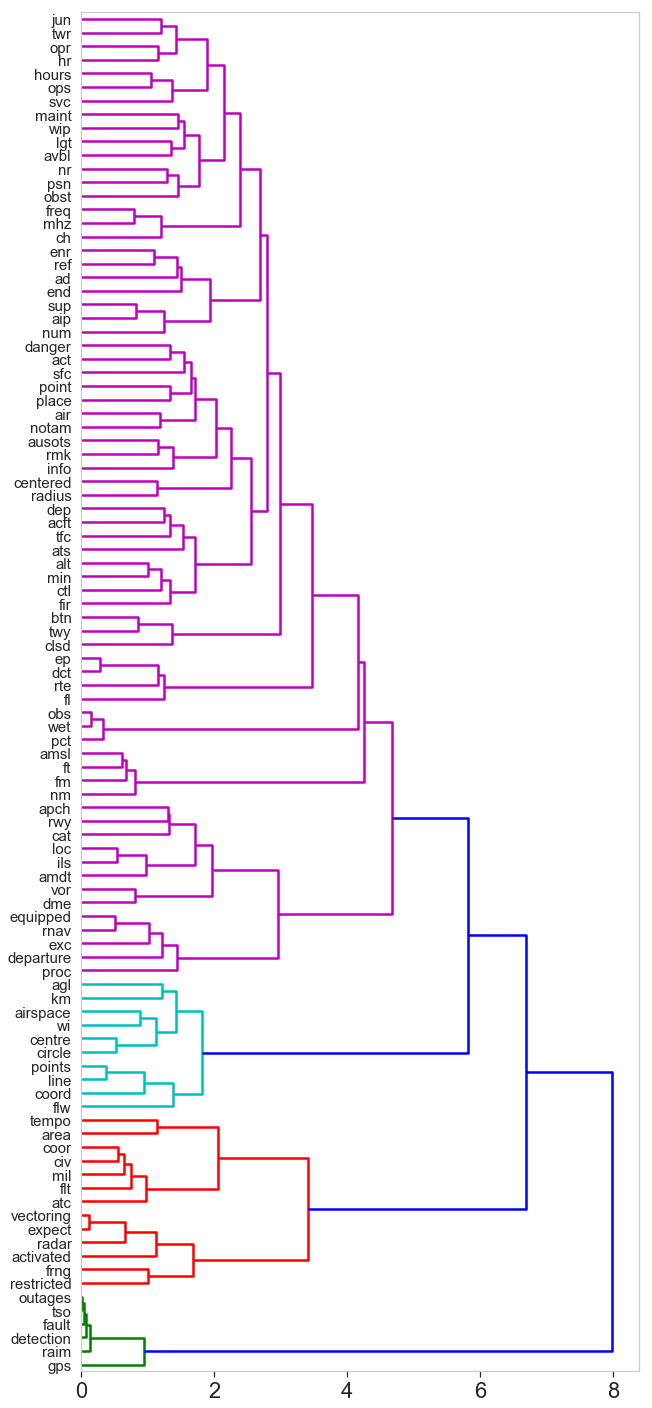

In [22]:
Z = linkage(cov, 'ward')
fig, ax = plt.subplots(figsize=(10, 25))
dn = dendrogram(Z, ax=ax, orientation='right', labels=feature_most_frequent)
ax.tick_params(axis='y', which='major', labelsize=15)
ax.grid(False)

## NOTAM clustering

### K-means tests

We use the Elbow method to determine the number of typical clusters. 4 seems to be a good choice, but we see from the t-SNE projection that the clusters are not so relevant.

In [23]:
if False:
    inertia = []
    for k in range(1, 20):
        print(k)
        kmeans = KMeans(n_clusters=k, random_state=20091982)
        kmeans.fit(vector_train)
        inertia.append(kmeans.inertia_)

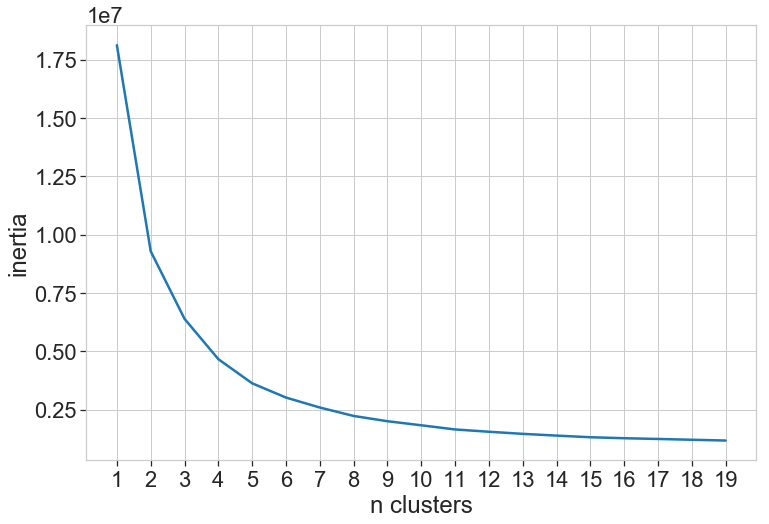

In [85]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(range(1, 20), np.array(inertia))
ax.set_xticks(range(1, 20))
ax.set_xlabel('n clusters')
ax.set_ylabel('inertia')
None

In [86]:
reload(modelling)

n_clusters = 50

# run K-means with n_clusters
path_out = data_dir+'/cluster_kmeans_k{}.pickle'.format(n_clusters)
model_options_dict = {'n_clusters': n_clusters, 'random_state': random_state}
model = modelling.cluster_train(
    vector_train, model_type='kmeans',
    model_options_dict=model_options_dict, path_out=path_out)

In [90]:
reload(modelling)

# evaluate test sample
labels_test = modelling.find_clusters_predict(vector_test, path_out, model_type='kmeans')

np.unique(labels_test)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 24, 25, 27, 29, 30, 31, 34, 35, 36, 39, 40,
       42, 45], dtype=int32)

In [91]:
reload(modelling)

# plot the t-SNE representation
path_tsne_html = path_tsne.replace('.csv', '_kmeans_k{}.html'.format(n_clusters))
modelling.plot_clusters(
    tsne_test, labels_test,
    text=model_test.get_df()['fulltext'],
    html_out=path_tsne_html,
    interactive=True)

Plotting 2684 points with label 0
Plotting 1 points with label 1
Plotting 23 points with label 2
Plotting 1 points with label 3
Plotting 564 points with label 4
Plotting 16 points with label 5
Plotting 57 points with label 6
Plotting 1 points with label 7
Plotting 182 points with label 8
Plotting 8 points with label 9
Plotting 1325 points with label 10
Plotting 1176 points with label 11
Plotting 3 points with label 12
Plotting 76 points with label 13
Plotting 260 points with label 14
Plotting 1 points with label 15
Plotting 9 points with label 16
Plotting 12 points with label 17
Plotting 12 points with label 18
Plotting 517 points with label 19
Plotting 57 points with label 20
Plotting 167 points with label 21
Plotting 108 points with label 22
Plotting 1129 points with label 24
Plotting 4 points with label 25
Plotting 27 points with label 27
Plotting 14 points with label 29
Plotting 10 points with label 30
Plotting 2670 points with label 31
Plotting 8169 points with label 34
Plotting 1

### Hierarchical clustering tests

We test the hierarchical clustering.

In [24]:
# first we compute the hierarchical
# clusters and distances
# we only use a sub set for 
# this step as it is time consuming

choice = np.random.choice(len(vector_train), size=10000)
Z = linkage(vector_train[choice, :], 'ward')

In [25]:
# then we compute number of clusters 
# at each stage, or:
# how many clusters are there with 
# larger distance than d?
n_clusters_list = []
for d in np.logspace(0, 3, 30):
    n_clusters = sum(Z[:,2] > d)
    print(n_clusters, '{0:.2f}'.format(d))
    n_clusters_list.append(n_clusters)
    
n_clusters_list = np.unique(n_clusters_list)

2764 1.00
2400 1.27
2037 1.61
1638 2.04
1310 2.59
1037 3.29
810 4.18
624 5.30
479 6.72
371 8.53
277 10.83
209 13.74
154 17.43
112 22.12
84 28.07
65 35.62
48 45.20
35 57.36
26 72.79
18 92.37
13 117.21
13 148.74
9 188.74
8 239.50
4 303.92
3 385.66
3 489.39
2 621.02
2 788.05
1 1000.00


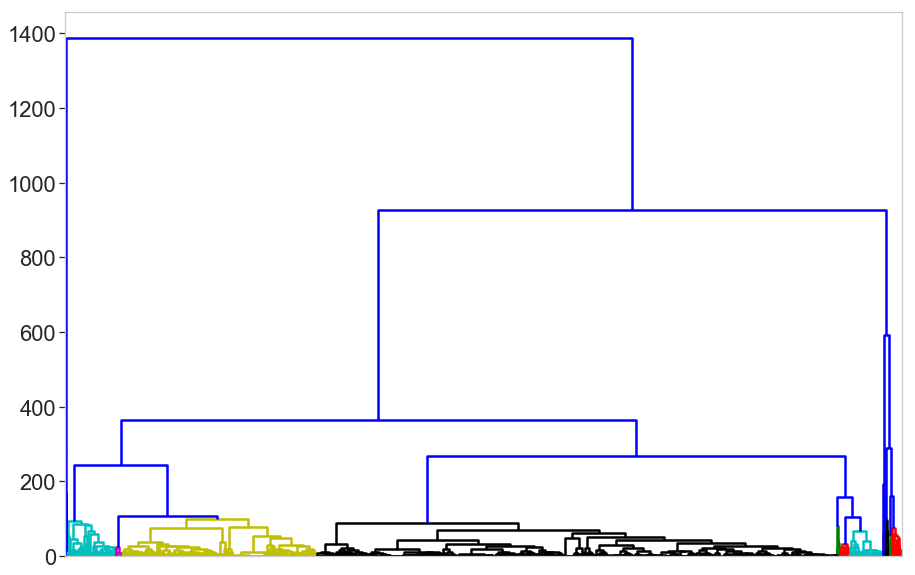

In [26]:
# visualize the clusters
fig, ax = plt.subplots(figsize=(15, 10))
dn = dendrogram(Z, ax=ax, no_labels=True, color_threshold=100)
ax.grid(False)
None

In [28]:
reload(modelling)

def cluster_purity(vector, target, k, size=5000):
    """ Compute the clusters
    and measure the purity
    """

    choice = np.random.choice(len(vector_train), size=size)

    # run hierachical clustering
    model_options_dict = {'n_clusters': k}
    model = modelling.find_clusters_train(
        vector[choice, :], model_type='hierarchical',
        model_options_dict=model_options_dict)
    
    labels = model.labels_
    classes = target[choice]

    N, purity, f_pure = modelling.get_cluster_purity(labels, classes)

    return N, purity, f_pure

N_4, purity_4, f_pure_4 = cluster_purity(vector_train, target_train, 4, size=5000)
N_50, purity_50, f_pure_50 = cluster_purity(vector_train, target_train, 50, size=5000)

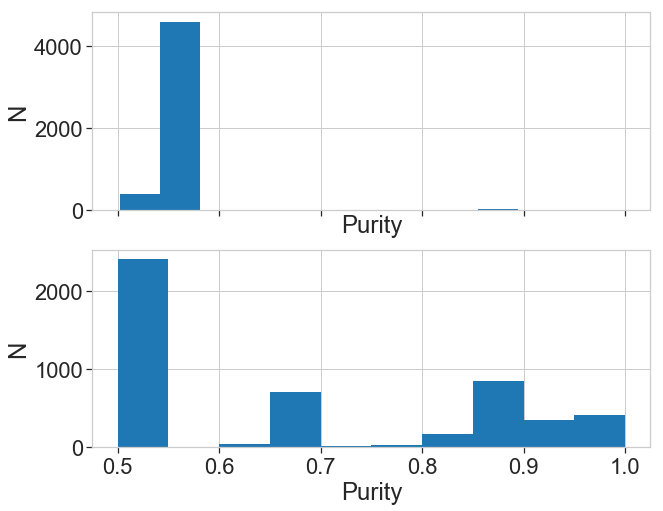

In [29]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
ax[0].hist(purity_4, weights=N_4, bins=10)
ax[0].set_xlabel('Purity')
ax[0].set_ylabel('N')

ax[1].hist(purity_50, weights=N_50, bins=10)
ax[1].set_xlabel('Purity')
ax[1].set_ylabel('N')

None

In [71]:
f_pure_list = []
for k in n_clusters_list:
    N, purity, f_pure = cluster_purity(vector_train, target_train, k, size=10000)
    f_pure_list.append(f_pure)
    
    print(k, f_pure)

1 0.0
2 0.0007
3 0.0007
5 0.0014
6 0.0013
9 0.0509
11 0.0551
12 0.0502
18 0.0661
25 0.1494
34 0.1703
50 0.3774
65 0.4243
83 0.4358
110 0.4823
148 0.5063
203 0.553
276 0.5765
370 0.5731
477 0.5871
632 0.6051
798 0.6401
1051 0.6546
1331 0.7073
1653 0.6985
2063 0.7077
2419 0.7598
2783 0.812


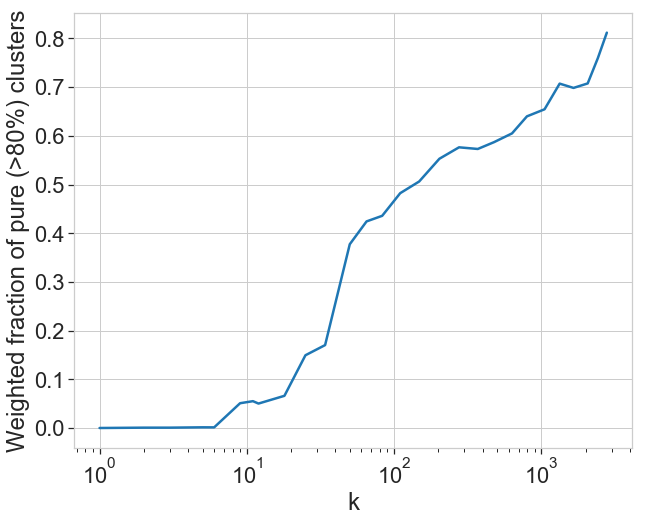

In [72]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(n_clusters_list, f_pure_list)
ax.set_xlabel('k')
ax.set_ylabel('Weighted fraction of pure (>80%) clusters')
ax.set_xscale('log')

In [40]:
reload(modelling)

# test with 50 clusters on the test sample
#choice = np.random.choice(len(vector_test), size=100)
choice = range(len(vector_test))

n_clusters = 50

# run hierachical clustering
path_out = data_dir+'/cluster_hierach_k{}.pickle'.format(n_clusters)
model_options_dict = {'n_clusters': n_clusters}
model = modelling.find_clusters_train(
    vector_test[choice, :], model_type='hierarchical',
    model_options_dict=model_options_dict, path_out=path_out)

In [32]:
vector_test[choice, :]

array([[ 1.00019315e+00,  1.78379160e-03,  4.64057779e-03, ...,
        -7.05927066e-02, -9.12630793e-03, -8.29833084e-02],
       [ 2.00294473e+00,  9.92685434e-03,  8.74720573e-02, ...,
        -1.72865003e-02, -1.09671796e-01,  1.72221907e-01],
       [ 2.00177811e+00,  1.61633432e-02,  4.59790936e-02, ...,
        -3.81881479e-03, -4.62263344e-02,  2.94436380e-02],
       ...,
       [ 6.00121360e+00, -6.50120415e-03,  1.94596515e-02, ...,
        -1.62361707e-02, -8.43110020e-02, -6.46628773e-02],
       [ 6.00143810e+00,  9.15900818e-03,  3.59118225e-02, ...,
         1.08928174e-01, -1.93787414e-01,  2.02667527e-01],
       [ 2.29873306e-07,  7.32508070e-08,  2.53333553e-05, ...,
        -3.84891847e-05, -6.42926463e-04, -1.20778918e-04]])

In [39]:
reload(modelling)

# plot the t-SNE representation
path_tsne_html = path_test_TSNE.replace('.csv', '_hierach_k{}.html'.format(50))
modelling.plot_clusters(
    test_TSNE[choice, :], model.labels_,
    text=model_test.get_df()['fulltext'].iloc[choice],
    html_out=path_tsne_html,
    interactive=True)

Plotting 2 points with label 0
Plotting 3 points with label 1
Plotting 11 points with label 2
Plotting 4 points with label 3
Plotting 2 points with label 4
Plotting 3 points with label 5
Plotting 3 points with label 6
Plotting 5 points with label 7
Plotting 3 points with label 8
Plotting 2 points with label 9
Plotting 2 points with label 10
Plotting 2 points with label 11
Plotting 2 points with label 12
Plotting 1 points with label 13
Plotting 1 points with label 14
Plotting 1 points with label 15
Plotting 4 points with label 16
Plotting 4 points with label 17
Plotting 3 points with label 18
Plotting 1 points with label 19
Plotting 5 points with label 20
Plotting 1 points with label 21
Plotting 5 points with label 22
Plotting 2 points with label 23
Plotting 1 points with label 24
Plotting 2 points with label 25
Plotting 1 points with label 26
Plotting 1 points with label 27
Plotting 1 points with label 28
Plotting 1 points with label 29
Plotting 1 points with label 30
Plotting 1 points

In [13]:
reload(modelling)

path_in = ''

# read model
with open(path_in, 'rb') as file_in:
    vector_train, labels_train = pickle.load(file_in)

FileNotFoundError: [Errno 2] No such file or directory: ''

In [220]:
reload(modelling)

# try with X_train_50

# run hierachical clustering with 4 clusters
path_out = data_dir+'/23-08-2018/cluster_hierarchical_k7.pickle'
model_options_dict = {'n_clusters': 55}
model = modelling.cluster_train(
    X_test_50, n_samples=None, model_type='hierarchical',
    model_options_dict=model_options_dict, path_out=path_out)

In [221]:
np.unique(model.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54])

In [222]:
#n = 1000
modelling.plot_clusters(
    X_test,  model.labels_, text=text_test,
    html_out=path_out.replace('.pickle', '.html'), 
    X_decomposed=X_test_TSNE,
    interactive=True, random_state=20091982)

Plotting 4 points with label 0
Plotting 52 points with label 1
Plotting 102 points with label 2
Plotting 3805 points with label 3
Plotting 315 points with label 4
Plotting 93 points with label 5
Plotting 21 points with label 6
Plotting 234 points with label 7
Plotting 19 points with label 8
Plotting 7 points with label 9
Plotting 4 points with label 10
Plotting 1039 points with label 11
Plotting 15 points with label 12
Plotting 139 points with label 13
Plotting 201 points with label 14
Plotting 18 points with label 15
Plotting 1115 points with label 16
Plotting 8 points with label 17
Plotting 30 points with label 18
Plotting 362 points with label 19
Plotting 86 points with label 20
Plotting 57 points with label 21
Plotting 2995 points with label 22
Plotting 100 points with label 23
Plotting 1289 points with label 24
Plotting 3 points with label 25
Plotting 63 points with label 26
Plotting 1 points with label 27
Plotting 43 points with label 28
Plotting 1 points with label 29
Plotting 1

In [223]:
sum(supress_test == 0)

10665

In [224]:
label_types = np.unique(model.labels_)
n_labels = len(label_types)
N = np.zeros(n_labels)
purity = np.zeros(n_labels)

for i,l in enumerate(label_types):
    
    select = model.labels_ == l
    N[i] = sum(select)
    
    #print(N, sum(supress_test.iloc[select] == 1))
    
    f_important = sum(supress_test[select] == 0)/N[i]
    f_unimportant = sum(supress_test[select] == 1)/N[i]
    
    purity[i] = max(f_important, f_unimportant)
    
    print(N[i], '{0:.2f}'.format(purity[i]))


4.0 1.00
52.0 1.00
102.0 0.52
3805.0 0.62
315.0 0.95
93.0 0.56
21.0 0.71
234.0 0.52
19.0 0.74
7.0 1.00
4.0 1.00
1039.0 0.55
15.0 0.87
139.0 1.00
201.0 0.88
18.0 0.94
1115.0 0.58
8.0 1.00
30.0 0.57
362.0 0.58
86.0 0.52
57.0 0.58
2995.0 0.64
100.0 1.00
1289.0 0.94
3.0 0.67
63.0 0.78
1.0 1.00
43.0 1.00
1.0 1.00
1.0 1.00
1.0 1.00
439.0 0.84
1.0 1.00
1879.0 0.53
187.0 0.96
64.0 0.97
3398.0 0.88
246.0 1.00
2.0 1.00
6.0 1.00
13.0 1.00
62.0 0.92
325.0 1.00
5.0 1.00
120.0 1.00
3.0 0.67
1.0 1.00
4.0 1.00
1.0 1.00
6.0 0.67
1.0 1.00
15.0 0.80
3.0 1.00
706.0 1.00


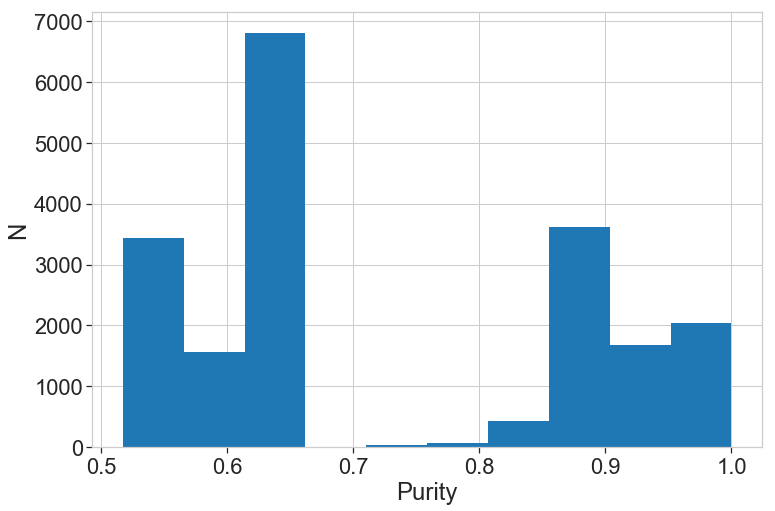

In [225]:
# 115
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(purity, weights=N, bins=10)
ax.set_xlabel('Purity')
ax.set_ylabel('N')
None

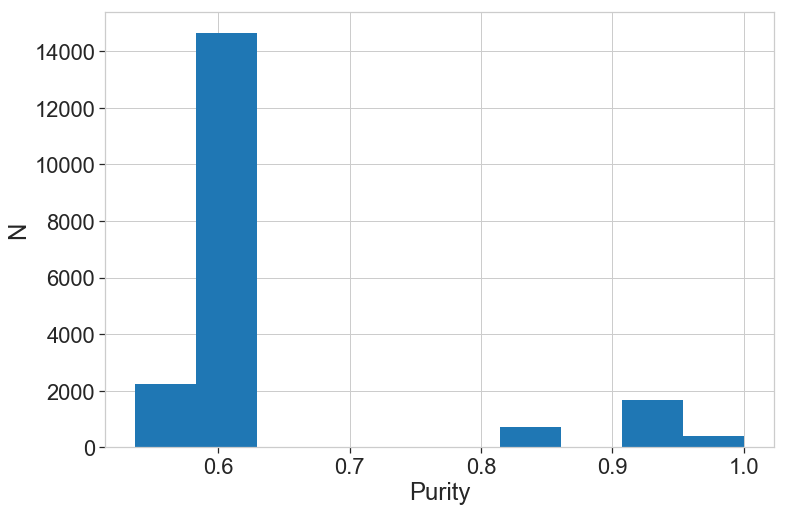

In [214]:
# 27
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(purity, weights=N, bins=10)
ax.set_xlabel('Purity')
ax.set_ylabel('N')
None

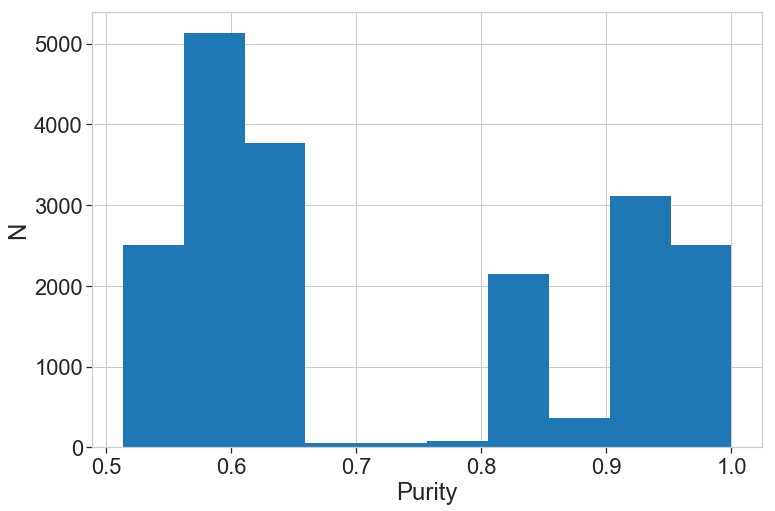

In [208]:
# 75
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(purity, weights=N, bins=10)
ax.set_xlabel('Purity')
ax.set_ylabel('N')
None

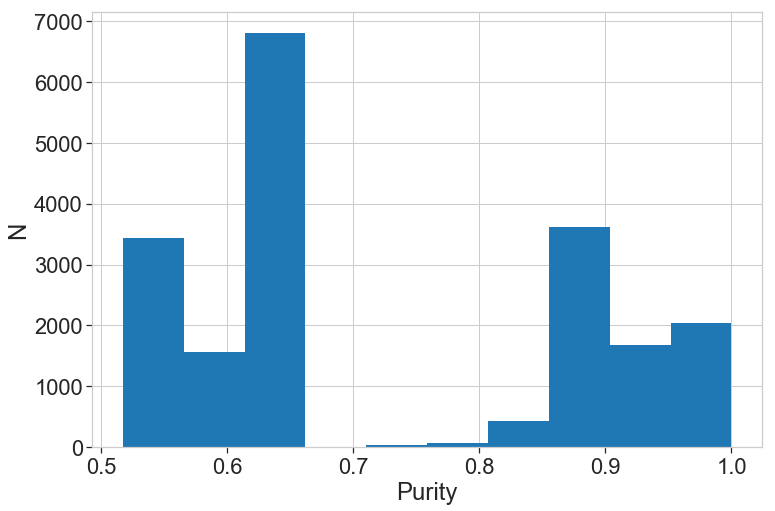

In [203]:
# 50
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(purity, weights=N, bins=10)
ax.set_xlabel('Purity')
ax.set_ylabel('N')
None

In [78]:
#choice = np.random.randint(most_frequent.shape[0], size=100)

In [26]:
choice = np.random.randint(word_counts.shape[0], size=5000)
counts_small = word_counts.toarray()[choice, :]

In [27]:
Z = linkage(counts_small, 'ward')

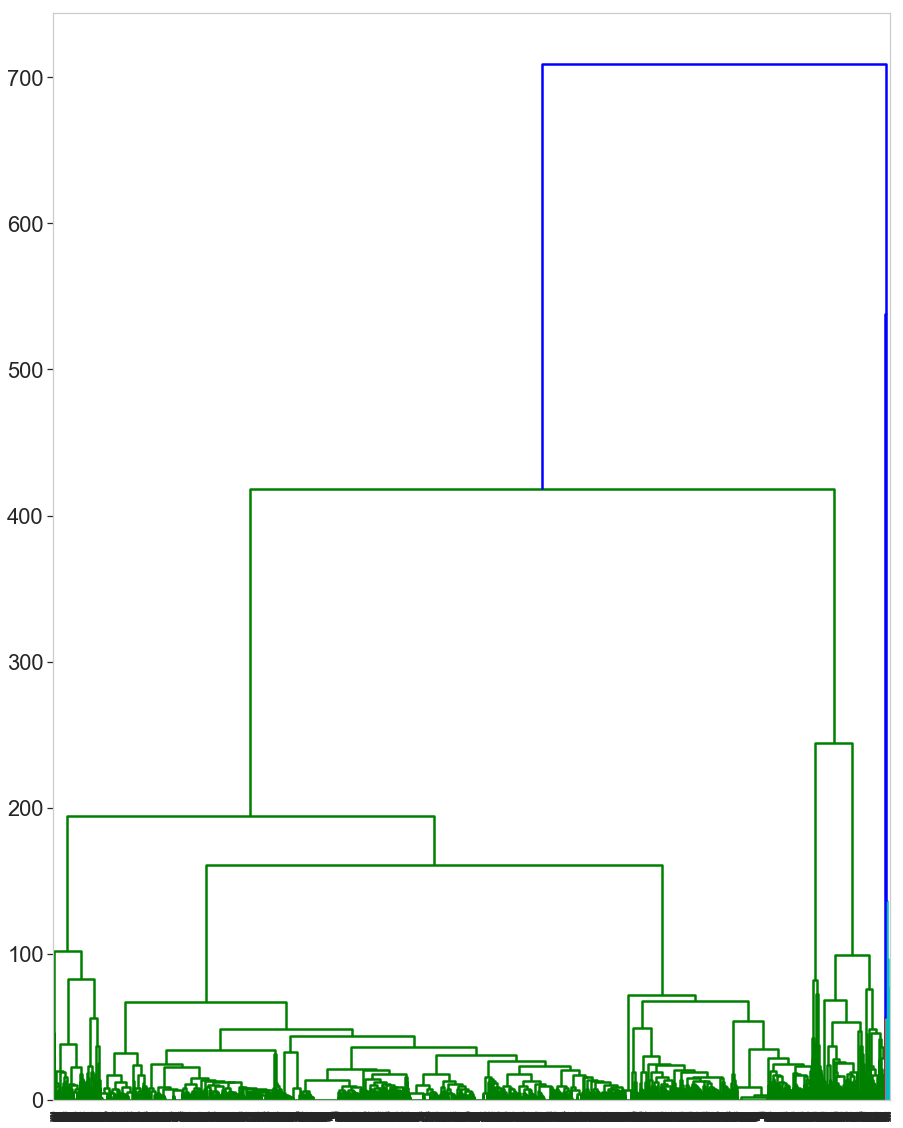

In [28]:
fig, ax = plt.subplots(figsize=(15, 20))
dn = dendrogram(Z, ax=ax)

#ax.tick_params(axis='y', which='major', labelsize=15)
ax.grid(False)

borromeo 3142


In [90]:
word_total_counts_sorted_ids[vectorizer.vocabulary_['ice']]

8228

In [72]:
# 1000 most frequent words
frequent = []
for index in word_total_counts_sorted_ids[:200]:
    frequent.append(inverse_dictionary[index]) #[word_total_counts_sorted_ids[-10:]]
np.array(frequent)

array(['num', 'coord', 'rwy', 'and', 'to', 'twy', 'clsd', 'of', 'area',
       'fl', 'at', 'acft', 'for', 'due', 'the', 'btn', 'not', 'wi', 'ft',
       'avbl', 'on', 'nm', 'will', 'with', 'act', 'radius', 'ad', 'ils',
       'fm', 'aip', 'be', 'gps', 'mil', 'as', 'mhz', 'flt', 'rte', 'dme',
       'by', 'amsl', 'activated', 'airspace', 'wip', 'in', 'wet', 'flw',
       'exc', 'take', 'all', 'obs', 'place', 'km', 'agl', 'or', 'vor',
       'ref', 'sfc', 'dct', 'pct', 'info', 'maint', 'rmk', 'restricted',
       'raim', 'cat', 'radar', 'amdt', 'tempo', 'atc', 'psn', 'no', 'ep',
       'lgt', 'loc', 'apch', 'freq', 'are', 'ops', 'hr', 'min', 'is',
       'rnav', 'twr', 'circle', 'only', 'side', 'expect', 'proc',
       'system', 'tfc', 'ats', 'notam', 'may', 'opr', 'centre',
       'vectoring', 'end', 'danger', 'detection', 'point', 'line', 'jun',
       'fir', 'ctl', 'svc', 'fault', 'ch', 'hours', 'tso', 'obst',
       'outages', 'alt', 'ausots', 'civ', 'sup', 'enr', 'eg', 'either',
   

In [115]:
# 1000 least frequent words
frequent = []
for index in word_total_counts_sorted_ids[18361-200:18361]:
    frequent.append(inverse_dictionary[index]) #[word_total_counts_sorted_ids[-10:]]
np.array(frequent)

array(['budworth', 'stilt', 'lepar', 'wymagaja', 'ytra', 'steza', 'ehrd',
       'araclarini', 'tuxxi', 'maleme', 'gitle', 'effects', 'stephens',
       'guimaraes', 'sokobanja', 'chiristie', 'guinea', 'chiquita',
       'stetten', 'stettenhofen', 'budowlane', 'letala', 'letal', 'gitam',
       'let', 'lesznowola', 'ytst', 'gisto', 'efkt', 'gurag', 'ehdl',
       'laskun', 'vsa', 'lapwing', 'gimun', 'daman', 'lapex', 'lapan',
       'stubs', 'stud', 'strzelin', 'gvo', 'laoag', 'whereas',
       'chichester', 'studley', 'vichy', 'lans', 'electronic', 'wenlock',
       'studenternas', 'laren', 'strzelce', 'managers', 'lasno', 'leaf',
       'chieti', 'wamm', 'dobson', 'strovolos', 'elavo', 'dobrovice',
       'chico', 'cinsi', 'lashenden', 'bulboaca', 'gomes', 'elbak',
       'lasers', 'larnaca', 'catly', 'lari', 'vuosanka', 'softspots',
       'elektirik', 'elektrocieplowni', 'vicenza', 'subitem',
       'elicottero', 'landfill', 'turned', 'catiii', 'elimina', 'gzg',
       'yr', 'lamun

In [38]:
#print(word_total_counts[10])
print(word_counts[1000])
vectorizer.inverse_transform(word_counts[1000])

  (0, 11975)	1
  (0, 7181)	1
  (0, 19706)	1
  (0, 12876)	2
  (0, 4165)	1
  (0, 632)	1
  (0, 9386)	1
  (0, 14468)	1
  (0, 499)	3
  (0, 23034)	1
  (0, 8584)	1
  (0, 27495)	2
  (0, 1580)	1
  (0, 4653)	1
  (0, 20732)	1
  (0, 17944)	1
  (0, 4532)	1
  (0, 5106)	10
  (0, 17610)	7


'aa'

In [41]:
vectorizer.get_feature_names()[23034]

'side'

In [12]:
# vectorizer.inverse_transform(np.argsort(word_total_counts)[:100])
(word_total_counts)

[array(['aa', 'aaa', 'aab', ..., 'zz', 'zzor', 'zzp'], dtype='<U32')]

In [15]:
#print(vectorizer.vocabulary_)

In [33]:
choice = np.random.randint(counts.shape[0], size=1000)
counts_small = counts.toarray()[choice, :]

# word vectors using TF-IDF
#X_sparse = transformer.fit_transform(counts)

#counts.toarray()
# X_sparse = counts
#X = X_sparse.toarray()

In [34]:
sum(sum(counts_small > 0))

12124

In [41]:
cov = np.corrcoef(counts_small, rowvar=False)
cov[~np.isfinite(cov)] = 0.0

/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[None, :]
/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [56]:
#cov.shape
#cov.shape

cov_highest = np.argsort(cov.ravel())


# what are the most correlated features?
#np.unravel_index(cov.argmax(), cov.shape)

#print(cov)


In [57]:
indices = np.unravel_index(cov_highest, cov.shape)

In [ ]:
#cov.shape[0]

sum(indices[0] == indices[1])

#vectorizer.inverse_transform(indices[0][40000:40100])

In [24]:
# how many words appear less than 10 times?

#word_sum = np.sum(counts, axis=0)
#print(word_sum.shape)

print(word_sum.shape)
word_sum[word_sum <= 10].shape

(1, 28657)


(1, 23036)

In [17]:
# X_small = np.random.choice(X_sparse.toarray(), 100)


#cov = np.cov(X_sparse.toarray().T)

ValueError: a must be 1-dimensional

In [ ]:

#X_embedded = X_small

In [ ]:
pd.DataFrame(X).corr()

In [455]:
X[0, 1000:2000]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [85]:
counts = vectorizer.fit_transform(corpus)
X_sparse = transformer.fit_transform(counts)
# X_sparse = counts
X = X_sparse.toarray()

In [222]:
choice = np.random.randint(X.shape[0], size=5000)
X_small = X[choice, :]
y_small = df['supress'].values[choice]

In [223]:
#text_small = df['fulltext'].values[choice]
#text_small

In [244]:
def break_lines(input_text, stride=60):
    """Break lines for a list of texts"""

    output_text = []
    for text in input_text:
        string = ''
        ids = range(0, len(text), stride)
        for start,end in zip(ids[:-1], ids[1:]):
            string += text[start: end]+'<br>'
        string += text[end:]

        output_text.append(string)
    
    return np.array(output_text)

text_small = break_lines(df['fulltext'].values[choice])

#text_small

#type(text_small)
#text_small

array(['J5283/18 NOTAMR J5268/18 Q)RJJJ/QANCA/I/NBO/E/000/999/3812N1<br>3646E242 A)RJJJ B)1806290528 C)1806292100 E)REF AIP ENR 3.3 <br>CDR ARE ESTABLISHED AS FLW,     RTE         PERIOD          <br>       MNM APPLICABLE ALT 1)  Z16         1806291300/1806292<br>100  MEA 2)  Z17         1806291300/1806292100  MEA 3)  Z18 <br>        1806290800/1806292100  MEA 4)  Z21         180629080<br>0/1806292100  MEA 5)  Z162        1806290800/1806292100  MEA<br> 6)  Z171        1806290800/1806292100  MEA 7)  Z182        <br>1806290800/1806292100  MEA',
       'A1169/18 NOTAMN Q)PHZH/QMXHW/IV/M/A/000/999/2054N15626W005 A<br>)PHOG B)1806021030 C)1806021530 E)TWY E BTN RWY 02/20 AND EA<br>ST RAMP WIP SFC PAINTING',
       'M3749/18 NOTAMN Q)EBBU/QRTCA/IV/BO/W/095/999/5010N00455E039 <br>A)EBBU B)1806261300 C)1806280850 D)26 1300-1350, 28 0800-085<br>0 E)TEMPO SEGREGATED AREA EBTSA26A ARDENNES 01 ACTIVATED. -D<br>URING ACT EBTSA26A IS NOT PERMEABLE AND TG1 IS CLOSED. -GAT <br>TRAFFIC IS ALLOWED TO CR

In [225]:
# from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(X_small)

#from sklearn.decomposition import PCA
#pca = PCA(n_components=2)
#X_embedded = pca.fit_transform(X_small)

X_embedded.shape

(5000, 2)

In [226]:
print(sum(X_small[0]))

1.6504895951782452


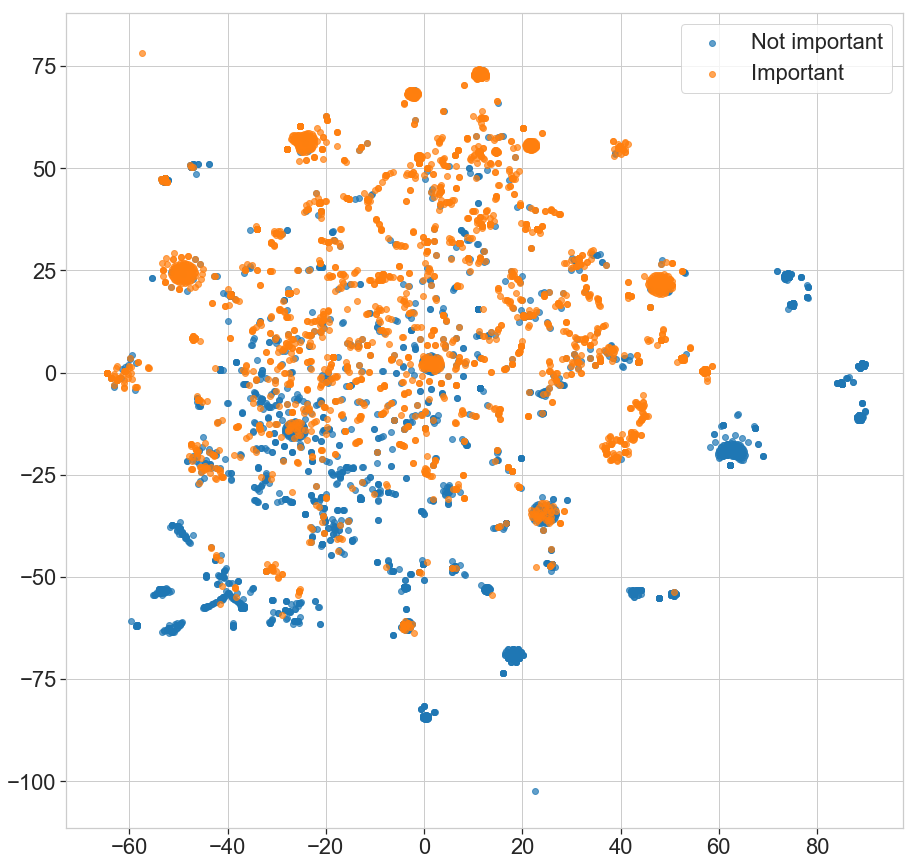

In [227]:
fig, ax = plt.subplots(figsize=(15, 15))
x = X_embedded[:, 0]
y = X_embedded[:, 1]


#z = X_embedded[:, 2]

sup = y_small == 1
ax.scatter(x[sup], y[sup], label='Not important', alpha=0.7)
ax.scatter(x[~sup], y[~sup], label='Important', alpha=0.7)
ax.legend(frameon=True)

In [94]:
import plotly
plotly.__version__

'3.2.1'

In [230]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

plotly.offline.init_notebook_mode(connected=True)

#plotly.offline.iplot({
#    "data": [go.Scatter(x=[1, 2, 3, 4], y=[4, 3, 2, 1])],
#    "layout": go.Layout(title="hello world")
#})

trace0 = go.Scatter(
    x = x[sup],
    y = y[sup],
    #z = z[sup],

    name = 'Not important',
    mode = 'markers',
    marker = dict(
        size = 5,
    ),
    text = text_small[sup]
)

trace1 = go.Scatter(
    x = x[~sup],
    y = y[~sup],
    #z = z[sup],
    name = 'Important',
    mode = 'markers',
    marker = dict(
        size = 5,
    ),
    text = text_small[~sup]
)


data = [trace0, trace1]

layout= go.Layout(
    autosize=False,
    width=1000,
    height=1000,

    title= 'NOTAMs/t-SNE',
    hovermode= 'closest',
    xaxis= dict(
        title= 'x',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'y',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)


fig = dict(data=data, layout=layout)
#plotly.offline.iplot(fig)
plotly.offline.plot(fig, filename='NOTAM_t_SNE.html')


'file:///Users/coupon/projects/propulsion/Swiss/3_Modelling/NOTAM_t_SNE.html'

## Gensim

In [306]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import corpora, models, similarities


# remove common words and tokenize
stoplist = set('for a of the and to in'.split())
texts = [[word for word in document.lower().split() if word not in stoplist]
         for document in df['text_clean'].fillna('').values]


#models.TfidfModel


In [304]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(texts)]
#documents

In [425]:
model = models.doc2vec.Doc2Vec(vector_size=500, min_count=1, window=1)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

TypeError: initialize() missing 2 required positional arguments: 'self' and 'corpus'

In [429]:
models.TfidfModel(texts)

ValueError: too many values to unpack (expected 2)

In [419]:
vectors = np.zeros((len(documents), 500))
for i,t in enumerate(documents):
    vectors[i,:] = model.docvecs[i]
    
X = vectors


choice = np.random.randint(X.shape[0], size=5000)
X_small = X[choice, :]
y_small = df['supress'].values[choice]

#X_embedded = X_small

# from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(X_small)

#from sklearn.decomposition import PCA
#pca = PCA(n_components=2)
#X_embedded = pca.fit_transform(X_small)

X_embedded.shape

(5000, 2)

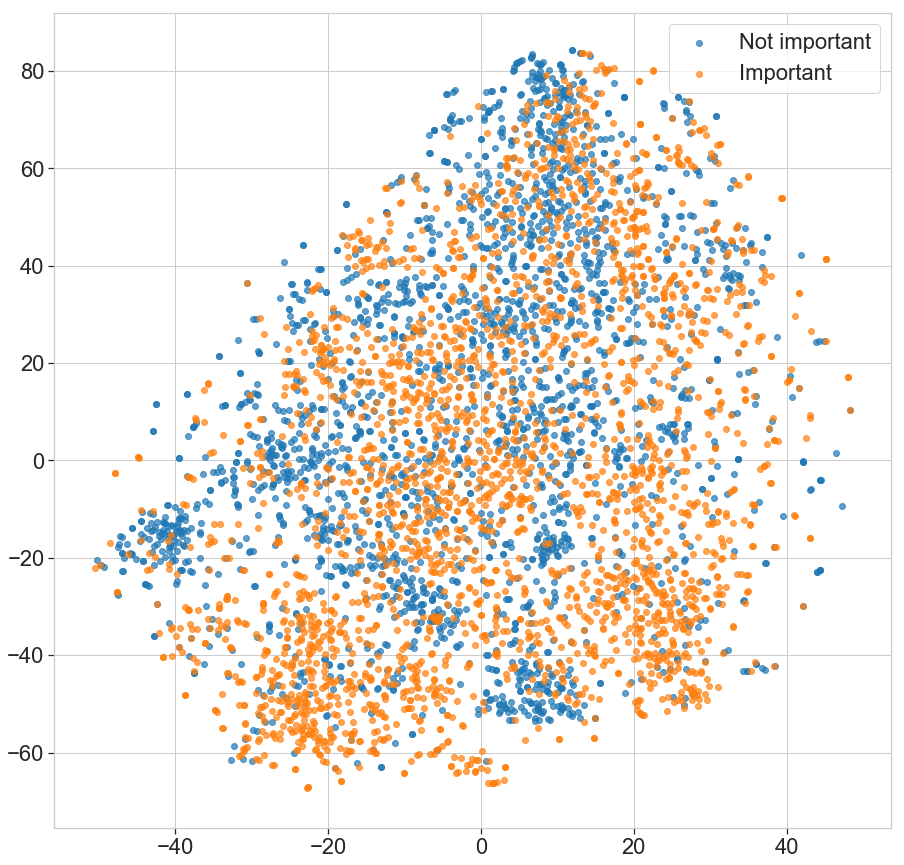

In [421]:
fig, ax = plt.subplots(figsize=(15, 15))
x = X_embedded[:, 0]
y = X_embedded[:, 1]

sup = y_small == 1
ax.scatter(x[sup], y[sup], label='Not important', alpha=0.7)
ax.scatter(x[~sup], y[~sup], label='Important', alpha=0.7)
ax.legend(frameon=True)

In [344]:
vec = documents[1].words
print(vec)

sims = model.docvecs.most_similar([model.docvecs[1]], topn=len(model.docvecs))

#print(sims[0][0])
print(documents[sims[4][0]])


['airborne', 'warning', 'ctl', 'system', 'flight', 'will', 'take', 'place', 'area', '<coord>', '<coord>', '<coord>', '<coord>']
TaggedDocument(['airborne', 'warning', 'ctl', 'system', 'will', 'take', 'place', 'area', '<coord>', '<coord>', '<coord>', '<coord>', 'area', 'clsd', 'tfc', 'btn', 'fl<num>', 'fl<num>'], [61654])


In [317]:
vectors = np.zeros((len(documents), 50))
for i,t in enumerate(documents):
    vectors[i,:] = model.infer_vector(t.words)
    
    
    #print( vectors[i,:])
    #break

In [258]:
# remove common words and tokenize
stoplist = set('for a of the and to in'.split())
texts = [[word for word in document.lower().split() if word not in stoplist]
         for document in corpus]

# remove words that appear only once
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1
texts = [[token for token in text if frequency[token] > 1]
         for text in texts]

from pprint import pprint  # pretty-printer
#pprint(texts)

In [296]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(texts)]
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

In [298]:
vectors = np.zeros((len(texts), 5))
for i,t in enumerate(texts):
    vectors[i,:] = model.infer_vector(t)

In [ ]:
texts[10]

In [268]:


dictionary = corpora.Dictionary(texts)
#print(dictionary.token2id)

In [278]:
#corpus = [dictionary.doc2bow(text) for text in texts]
print(corpus)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [273]:
tfidf = models.TfidfModel(corpus)
tfidf

#index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features=12)

In [282]:
tfidf[corpus[10]]

[(30, 0.06720827110149225),
 (77, 0.10703027966446861),
 (78, 0.24867227945645176),
 (79, 0.3455633128625216),
 (80, 0.1222257253141751),
 (81, 0.3656720578386301),
 (82, 0.32170026033756605),
 (83, 0.29888933903896886),
 (84, 0.09131788555010037),
 (85, 0.36831392715911954),
 (86, 0.12229327552443915),
 (87, 0.40419493285427227),
 (88, 0.3727885343122836)]

TypeError: 'int' object is not iterable

In [353]:
print(list(model.docvecs))

KeyError: "tag '98547' not seen in training corpus/invalid"

In [357]:
vectors = np.zeros((len(documents), 50))
for i,t in enumerate(documents):
    vectors[i,:] = model.docvecs[i]
    
X = vectors


choice = np.random.randint(X.shape[0], size=100)
X_small = X[choice, :]
y_small = df['supress'].values[choice]

# from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(X_small)

#from sklearn.decomposition import PCA
#pca = PCA(n_components=2)
#X_embedded = pca.fit_transform(X_small)

X_embedded.shape

(100, 2)

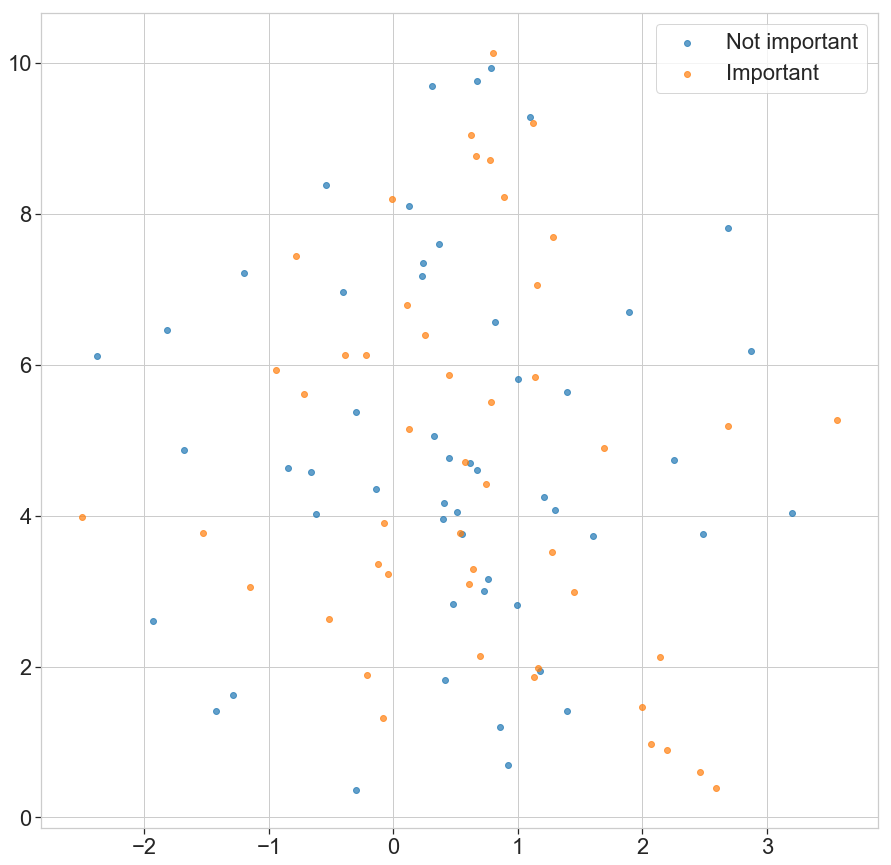

In [360]:
fig, ax = plt.subplots(figsize=(15, 15))
x = X_embedded[:, 0]
y = X_embedded[:, 1]

sup = y_small == 1
ax.scatter(x[sup], y[sup], label='Not important', alpha=0.7)
ax.scatter(x[~sup], y[~sup], label='Important', alpha=0.7)
ax.legend(frameon=True)

In [422]:
text_small = break_lines(df['fulltext'].values[choice])


plotly.offline.init_notebook_mode(connected=True)

#plotly.offline.iplot({
#    "data": [go.Scatter(x=[1, 2, 3, 4], y=[4, 3, 2, 1])],
#    "layout": go.Layout(title="hello world")
#})

trace0 = go.Scatter(
    x = x[sup],
    y = y[sup],
    #z = z[sup],

    name = 'Not important',
    mode = 'markers',
    marker = dict(
        size = 5,
    ),
    text = text_small[sup]
)

trace1 = go.Scatter(
    x = x[~sup],
    y = y[~sup],
    #z = z[sup],
    name = 'Important',
    mode = 'markers',
    marker = dict(
        size = 5,
    ),
    text = text_small[~sup]
)


data = [trace0, trace1]

layout= go.Layout(
    autosize=False,
    width=1000,
    height=1000,

    title= 'NOTAMs/t-SNE',
    hovermode= 'closest',
    xaxis= dict(
        title= 'x',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'y',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)


fig = dict(data=data, layout=layout)
#plotly.offline.iplot(fig)
plotly.offline.plot(fig, filename='NOTAM_t_SNE.html')



'file:///Users/coupon/projects/propulsion/Swiss/3_Modelling/NOTAM_t_SNE.html'